## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [109]:
import json
import numpy as np
import pandas as pd
import re, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import pos_tag as nltk_pos_tag

from wordcloud import WordCloud
# Download necessary resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [45]:
# Opening JSON file
# Open the file
with open('/content/complaints-2021-05-14_08_16.json', 'r') as f:
    # Load JSON data from the file
    data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [46]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [47]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [48]:
#Assign new column names
df.columns = df.columns.str.replace(r'^_source\.|^_', '', regex=True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [49]:
#Assign nan in place of blanks in the complaints column
df.complaint_what_happened.replace('', np.nan, inplace=True)
df.complaint_what_happened.head()

,complaint_what_happened
0,NaN
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,NaN
4,NaN


In [50]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [51]:
# function to clean the text and remove all the unnecessary elements.
def clean_complaint_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove text inside square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove words containing numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

In [52]:
#function to Lemmatize the texts

lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    # Tokenize the text
    words = word_tokenize(text)
    # Lemmatize each word as a noun
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a string
    return ' '.join(lemmatized_words)

In [53]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()
df_clean['complaints'] = df['complaint_what_happened']
df_clean['complaints'] = df_clean['complaints'].apply(clean_complaint_text)
df_clean['complaints'] = df_clean['complaints'].apply(lemmatize_text)

In [54]:
df_clean

,complaints
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and wa told by...
10,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it in...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yr ive had chas...


In [55]:
#function to extract the POS tags
def extract_pos_tags(text):
    words = word_tokenize(text)
    tagged_words = nltk_pos_tag(words)
    nouns = [word for word, tag in tagged_words if tag == 'NN']
    return ' '.join(nouns)

df_clean["complaint_POS_removed"] =  df_clean['complaints'].apply(extract_pos_tags)


The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.


In [56]:
df_clean

,complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...
78310,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...
78311,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...


## Exploratory data analysis to get familiar with the data.

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




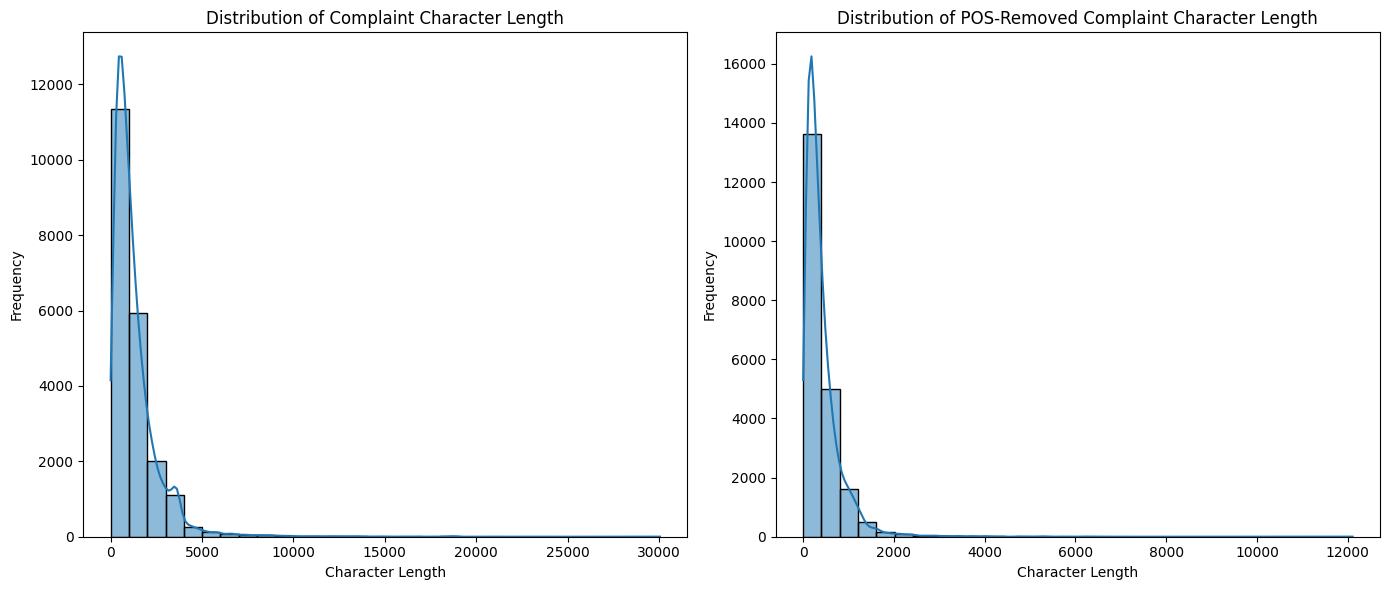

In [57]:
# Visualise the data according to the 'Complaint' character length
# Calculate the length of each complaint
df_clean['complaints_length'] = df_clean['complaints'].apply(len)
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].apply(len)

# Set up the plotting environment
plt.figure(figsize=(14, 6))

# Plot histogram for 'complaints' length
plt.subplot(1, 2, 1)
sns.histplot(df_clean['complaints_length'], bins=30, kde=True)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

# Plot histogram for 'complaint_POS_removed' length
plt.subplot(1, 2, 2)
sns.histplot(df_clean['complaint_POS_removed_length'], bins=30, kde=True)
plt.title('Distribution of POS-Removed Complaint Character Length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

# Show plots
plt.tight_layout()
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

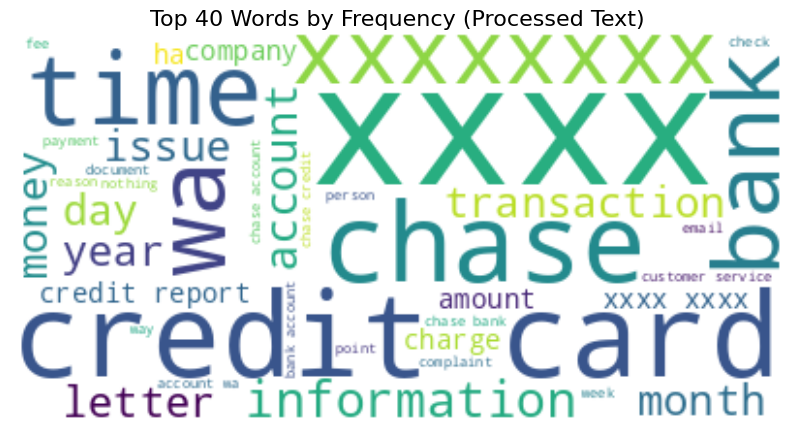

In [58]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Combine all the processed text into one large string
text = " ".join(df_clean['complaint_POS_removed'])
# Generate the word cloud
wordcloud = WordCloud(max_words=40, background_color='white').generate(text)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 40 Words by Frequency (Processed Text)", fontsize=16)
plt.show()


In [59]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

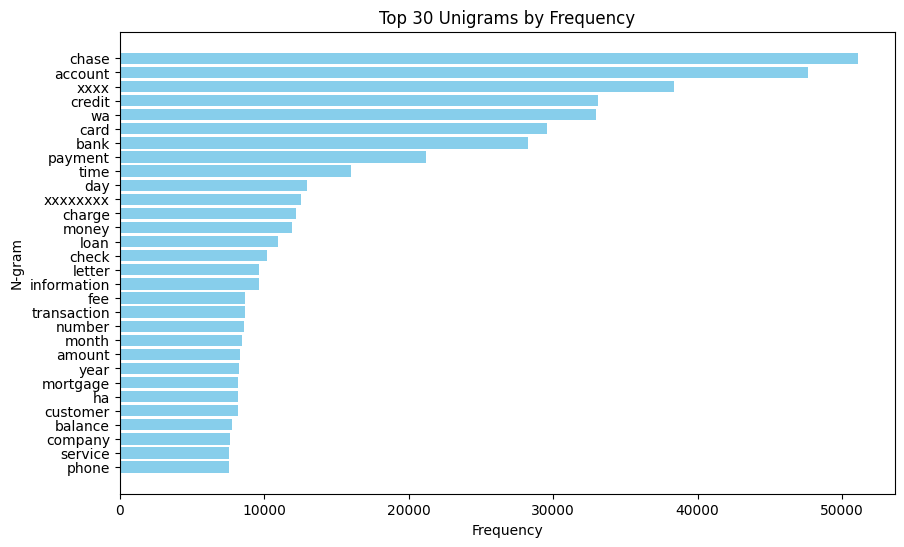

In [60]:
#Find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
# Function to plot the top n-grams
def plot_top_ngrams(if_print, ngram_range, top_n, title):
    # Initialize CountVectorizer for ngrams
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

    # Sum the occurrences of each n-gram
    ngram_counts = X.toarray().sum(axis=0)

    # Create a DataFrame of ngrams and their counts
    ngrams_freq = pd.DataFrame({'ngram': vectorizer.get_feature_names_out(), 'count': ngram_counts})

    # Sort the DataFrame by count
    ngrams_freq = ngrams_freq.sort_values(by='count', ascending=False).head(top_n)

    if not if_print:
      # Plot the top n-grams
      plt.figure(figsize=(10, 6))
      plt.barh(ngrams_freq['ngram'][::-1], ngrams_freq['count'][::-1], color='skyblue')
      plt.title(title)
      plt.xlabel('Frequency')
      plt.ylabel('N-gram')
      plt.show()
    else:
      return ngrams_freq


plot_top_ngrams(False, ngram_range=(1, 1), top_n=30, title='Top 30 Unigrams by Frequency')

In [61]:
#Print the top 10 words in the unigram frequency
plot_top_ngrams(True, ngram_range=(1, 1), top_n=10, title='Top 10 Unigrams by Frequency')

,ngram,count
2329,chase,51081
84,account,47647
15457,xxxx,38372
3441,credit,33094
14992,wa,32998
2011,card,29587
1196,bank,28234
10130,payment,21168
14122,time,16038
3700,day,12972


In [62]:
#Find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
plot_top_ngrams(True, ngram_range=(2, 2), top_n=30, title='Top 30 bigrams by Frequency')

,ngram,count
70257,credit card,12824
293163,xxxx xxxx,4098
70949,credit report,3876
73359,customer service,3085
48041,chase credit,3082
47472,chase account,2945
3557,account wa,2849
47666,chase bank,2822
24735,bank account,2809
1631,account chase,2762


In [63]:
#Print the top 10 words in the bigram frequency
plot_top_ngrams(True, ngram_range=(2, 2), top_n=10, title='Top 10 bigrams by Frequency')

,ngram,count
70257,credit card,12824
293163,xxxx xxxx,4098
70949,credit report,3876
73359,customer service,3085
48041,chase credit,3082
47472,chase account,2945
3557,account wa,2849
47666,chase bank,2822
24735,bank account,2809
1631,account chase,2762


In [64]:
#Find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
plot_top_ngrams(True, ngram_range=(3, 3), top_n=30, title='Top 30 trigrams by Frequency')

,ngram,count
161771,chase credit card,2116
231402,credit card account,1049
231597,credit card company,987
231565,credit card chase,682
402626,inquiry credit report,516
231647,credit card credit,475
819270,xxxx xxxx xxxx,421
8359,account credit card,405
237384,credit reporting agency,388
78570,bank credit card,383


In [65]:
#Print the top 10 words in the trigram frequency
plot_top_ngrams(True, ngram_range=(3, 3), top_n=10, title='Top 10 trigrams by Frequency')

,ngram,count
161771,chase credit card,2116
231402,credit card account,1049
231597,credit card company,987
231565,credit card chase,682
402626,inquiry credit report,516
231647,credit card credit,475
819270,xxxx xxxx xxxx,421
8359,account credit card,405
237384,credit reporting agency,388
78570,bank credit card,383


The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [66]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [67]:
#All masked texts has been removed
df_clean

,complaints,complaint_POS_removed,complaints_length,complaint_POS_removed_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,467,153,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,330,103,i card agent upgrade date agent wa information...
10,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,207,70,card wa application identity consent service c...
11,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1412,434,book ticket i offer ticket card i information...
14,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,449,170,son deposit chase account fund chase bank acco...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,619,234,chase card customer decade wa solicitation cre...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,2028,682,i chas visa credit card provider claim purcha...
78310,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2260,707,i pay risk consumer i bank app chase year mobi...
78311,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,1937,510,i credit credit card chase freedom problem ba...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [68]:
#TfidfVectorizer

# Initialize the TfidfVectorizer with specified parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [69]:
#Create the Document Term Matrix by transforming the complaints column present in df_clean.
# Fit and transform the 'complaint_POS_removed' column into TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

# Convert the TF-IDF matrix into a DataFrame for better readability (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the DataFrame with TF-IDF features
print(tfidf_df.head())

    aa  aarp   ab  abandonment  abatement  abbreviation  abd  abide  ability  \
0  0.0   0.0  0.0          0.0        0.0           0.0  0.0    0.0      0.0   
1  0.0   0.0  0.0          0.0        0.0           0.0  0.0    0.0      0.0   
2  0.0   0.0  0.0          0.0        0.0           0.0  0.0    0.0      0.0   
3  0.0   0.0  0.0          0.0        0.0           0.0  0.0    0.0      0.0   
4  0.0   0.0  0.0          0.0        0.0           0.0  0.0    0.0      0.0   

   about  ...  youth  youve   yr  ytd  zero  zeroed  zip  zipcode  zombie  \
0    0.0  ...    0.0    0.0  0.0  0.0   0.0     0.0  0.0      0.0     0.0   
1    0.0  ...    0.0    0.0  0.0  0.0   0.0     0.0  0.0      0.0     0.0   
2    0.0  ...    0.0    0.0  0.0  0.0   0.0     0.0  0.0      0.0     0.0   
3    0.0  ...    0.0    0.0  0.0  0.0   0.0     0.0  0.0      0.0     0.0   
4    0.0  ...    0.0    0.0  0.0  0.0   0.0     0.0  0.0      0.0     0.0   

   zone  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task I have to performed the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [70]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
Take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [72]:
#Load nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [76]:
nmf_model.fit(tfidf_matrix)
nmf_topics = nmf_model.transform(tfidf_matrix)
# Extract the feature names (words) from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [77]:
#Print the Top15 words for each of the topics
# Function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(nmf_model, tfidf_feature_names, 15)

Topic 0:
account bank check money fund chase wa deposit branch day fee checking business number customer
Topic 1:
card credit chase balance account fee interest limit year score month point wa purchase offer
Topic 2:
payment loan mortgage chase month modification home interest wa time year rate balance amount property
Topic 3:
inquiry report credit bureau company information reporting debt identity score theft letter jpmcb application account
Topic 4:
charge transaction chase dispute claim wa fraud merchant letter phone information time service number call


In [78]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
# Define the mapping of topic numbers to topic labels
topic_labels = {
    0: "Bank account services",
    1: "Credit card / Prepaid card",
    2: "Mortgages/loans",
    3: "Theft/Dispute reporting",
    4: "Others"
}


In [79]:
# Find the best topic for each complaint (the topic with the highest score)
complaint_topics = np.argmax(nmf_topics, axis=1)

In [87]:
#Assign the best topic to each of the cmplaints in Topic Column
# Create a new column in df_clean to store the best topic label for each complaint
df_clean['Topic_score'] = complaint_topics
df_clean['Topic'] = df_clean['Topic_score'].map(topic_labels)


In [88]:
df_clean.head()

,complaints,complaint_POS_removed,complaints_length,complaint_POS_removed_length,Complaint_clean,Topic_score,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,467,153,morning name stop bank cardmember service debt...,0,Bank account services
2,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,330,103,i card agent upgrade date agent wa information...,1,Credit card / Prepaid card
10,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,207,70,card wa application identity consent service c...,1,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1412,434,book ticket i offer ticket card i information...,3,Theft/Dispute reporting
14,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,449,170,son deposit chase account fund chase bank acco...,0,Bank account services


In [89]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaints,complaint_POS_removed,complaints_length,complaint_POS_removed_length,Complaint_clean,Topic_score,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,467,153,morning name stop bank cardmember service debt...,0,Bank account services
24,mishandling of this account by chase auto and ...,mishandling account auto xxxx,50,29,mishandling account auto,0,Bank account services
17,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday thursday b...,2198,647,jp chase account debit card tuesday thursday b...,0,Bank account services
14,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,449,170,son deposit chase account fund chase bank acco...,0,Bank account services
27,i opened an account with chase bank on xxxx an...,i account bank xxxx code bonus i term everythi...,392,125,i account bank code bonus i term everything w...,0,Bank account services
10,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,207,70,card wa application identity consent service c...,1,Credit card / Prepaid card
2,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,330,103,i card agent upgrade date agent wa information...,1,Credit card / Prepaid card
32,my chase amazon card wa declined for a caterin...,chase wa catering order i brother funeral amou...,1863,572,chase wa catering order i brother funeral amou...,1,Credit card / Prepaid card
50,i am a senior citizen that ha been scammed by ...,i citizen company xxxx time share company noth...,328,92,i citizen company time share company nothing ...,1,Credit card / Prepaid card
52,my roommate wa stealing my chase debit card an...,roommate wa chase debit card driver license mo...,718,231,roommate wa chase debit card driver license mo...,1,Credit card / Prepaid card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [85]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    0: "Bank account services",
    1: "Credit card / Prepaid card",
    2: "Mortgages/loans",
    3: "Theft/Dispute reporting",
    4: "Others"
}
#Replace Topics with Topic Names
df_clean_5['Topic'] = df_clean_5['Topic'].map(Topic_names)

<ipython-input-85-9c9a1aee10dd>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
df_clean_5[['complaints', 'Topic']]

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank account services
2,i upgraded my xxxx xxxx card in and wa told by...,Credit card / Prepaid card
10,chase card wa reported on however fraudulent a...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,Theft/Dispute reporting
14,my grand son give me check for i deposit it in...,Bank account services
15,can you please remove inquiry,Theft/Dispute reporting
17,with out notice jp morgan chase restricted my ...,Bank account services
20,during the summer month i experience a decline...,Mortgages/loans
21,on xxxx i made a payment to an online retailer...,Others
23,i have a chase credit card which is incorrectl...,Theft/Dispute reporting


## Supervised model to predict any new complaints to the relevant Topics.

Build the Supervised models to create the topics for each complaints. Use them to classify any new complaints.

Since supervised learning technique is used I have converted the topic names to numbers(numpy arrays only understand numbers)

In [96]:
df_clean.head()

,complaints,complaint_POS_removed,complaints_length,complaint_POS_removed_length,Complaint_clean,Topic_score,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,467,153,morning name stop bank cardmember service debt...,0,Bank account services
2,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,330,103,i card agent upgrade date agent wa information...,1,Credit card / Prepaid card
10,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,207,70,card wa application identity consent service c...,1,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1412,434,book ticket i offer ticket card i information...,3,Theft/Dispute reporting
14,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,449,170,son deposit chase account fund chase bank acco...,0,Bank account services


In [97]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaints', 'Topic']]

In [98]:
training_data

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank account services
2,i upgraded my xxxx xxxx card in and wa told by...,Credit card / Prepaid card
10,chase card wa reported on however fraudulent a...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,Theft/Dispute reporting
14,my grand son give me check for i deposit it in...,Bank account services
...,...,...
78303,after being a chase card customer for well ove...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,Others
78310,i am not familiar with xxxx pay and did not un...,Others
78311,i have had flawless credit for yr ive had chas...,Credit card / Prepaid card


####Apply the supervised models on the training data created.
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [103]:
#Get the Vector count

# Initialize CountVectorizer to convert complaints to word counts
count_vectorizer = CountVectorizer()

# Fit and transform the training data into word count vectors
data_counts = count_vectorizer.fit_transform(training_data['complaints'])


#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()

# Apply TfidfTransformer to convert word counts to TF-IDF
data_tfidf = tfidf_transformer.fit_transform(data_counts)

X_train, X_test, y_train, y_test = train_test_split(data_tfidf, training_data['Topic'], test_size=0.2, random_state=42)

Trying atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest


**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [110]:
# Build any 3 models and evaluate them using the required metrics
# Initialize a dictionary to store the models and their names
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler(with_mean=False)), # Use StandardScaler with sparse data (set `with_mean=False`)
        ('log_reg', LogisticRegression(random_state=42, max_iter=500)) # Increase max_iter
    ]),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Loop through each model, train it, predict, and evaluate its performance
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name}: {accuracy * 100:.2f}%")
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))


Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy of Logistic Regression: 79.95%
Classification Report for Logistic Regression:

                            precision    recall  f1-score   support

     Bank account services       0.81      0.82      0.82      1046
Credit card / Prepaid card       0.76      0.76      0.76       812
           Mortgages/loans       0.83      0.86      0.84      1003
                    Others       0.77      0.76      0.77       932
   Theft/Dispute reporting       0.83      0.78      0.81       422

                  accuracy                           0.80      4215
                 macro avg       0.80      0.80      0.80      4215
              weighted avg       0.80      0.80      0.80      4215


Training Decision Tree...
Accuracy of Decision Tree: 78.05%
Classification Report for Decision Tree:

                            precision    recall  f1-score   support

     Bank account services       0.77      0.80      0.78      1046
Credit card / Prepaid card       0.78      0.78      0.78

### Model Inference

Out of the three models, Random Forest stands out as the best performer with the highest accuracy and balanced performance across the topics. If we were to select a model for production, Random Forest would be our top choice due to its strength in handling diverse complaint types, followed by Logistic Regression, which also did a solid job but might require further tuning to optimize convergence.